In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from fastai.data.transforms import get_image_files, get_files
from fastai.vision.data import SegmentationDataLoaders
import os
from os import path
from fastseg.image import colorize, blend
from PIL import Image
from tqdm import tqdm
import albumentations as A
import math
from fastai.vision.all import Learner
from fastai.metrics import DiceMulti
from fastseg import MobileV3Small
from patchify import patchify, unpatchify
import sys
from io import StringIO
from IPython import get_ipython

class IpyExit(SystemExit):
    """Exit Exception for IPython.

    Exception temporarily redirects stderr to buffer.
    """
    def __init__(self):
        # print("exiting")  # optionally print some message to stdout, too
        # ... or do other stuff before exit
        sys.stderr = StringIO()

    def __del__(self):
        sys.stderr.close()
        sys.stderr = sys.__stderr__  # restore from backup


def ipy_exit():
    raise IpyExit


if get_ipython():    # ...run with IPython
    exit = ipy_exit  # rebind to custom exit
else:
    exit = exit      # just make exit importable

root_dir = "/media/nevin/Trash Games1/culane/"
base_dir = "/media/nevin/Trash Games1/culane/driver_23_30frame"
processed_dir = "/media/nevin/Trash Games1/culane/augmented"

5284


In [22]:
patches_dir = "/media/nevin/Trash Games1/culane/patches"

input_images = get_image_files(path.join(patches_dir, "images/"))

codes = ["lane"]

def label_func(input):
    return f"{patches_dir}/labels/{input.stem}_label.png"

print(label_func(input_images[0]))

dls = SegmentationDataLoaders.from_label_func(
    root_dir,
    input_images,
    label_func=label_func,
    codes=codes,
    bs=8
    # bs=4,
)


/media/nevin/Trash Games1/culane/patches/labels/00000_0_0_label.png


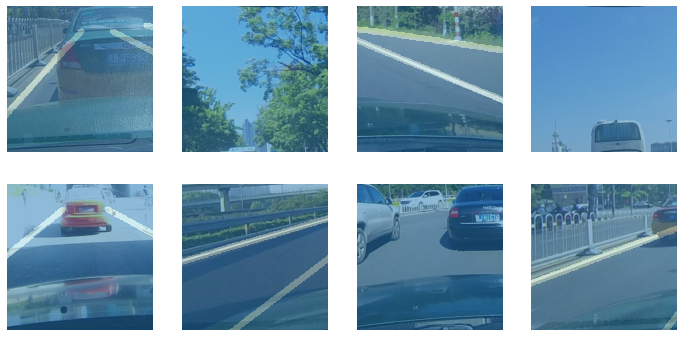

In [26]:
dls.show_batch(max_n=16)

In [27]:
model = MobileV3Small(num_classes=2, use_aspp=True)
learn = Learner(dls, model, metrics=[DiceMulti()])

In [30]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,dice_multi,time
0,0.053970,0.066138,0.712604,01:08


epoch,train_loss,valid_loss,dice_multi,time
0,0.047759,0.059787,0.759726,01:09
1,0.041057,0.059499,0.766451,01:08


In [31]:
learn.export("/media/nevin/Trash Games1/culane/model_new_1.pk")

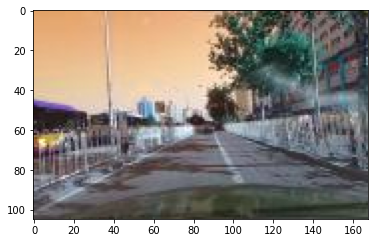

In [21]:
plt.imshow(img)

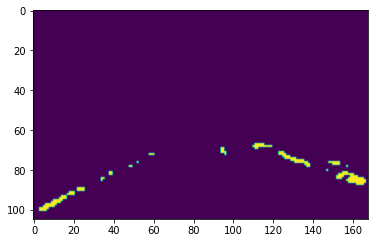

In [20]:
img = cv.imread(str(input_images[300]))
plt.imshow(learn.predict(img)[0])

In [5]:
patches_dir = "/media/nevin/Trash Games1/culane/patches/"

dirs = os.listdir(base_dir)

output = []

for dir in dirs:
    dir = path.join(base_dir, dir)
    images = get_image_files(dir)
    step = math.floor(len(images) / 14)
    if step == 0:
        continue
    for i in range(0, len(images), step):
        output.append(images[i])

# print(len(output))
print(len(output))

def get_points(label_file):
    with open(label_file) as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]

    points = [[] for line in lines]
    for idx, line in enumerate(lines):
        split = line.split(" ")
        for i in range(0, len(split), 2):
            points[idx].append([int(float(split[i])), int(float(split[i + 1]))]) # it works
    
    return np.array(points, dtype=object)


def gen_seg(image, points):
    h, w, c = image.shape
    seg_image = np.zeros((h, w), np.uint8)
    for i in range(len(points)):
        point = np.asarray(points[i])
        x = point[:, 0]
        y = point[:, 1]

        draw_points = (np.asarray([x, y]).T).astype(np.int32)

        seg_image = cv.polylines(seg_image, [draw_points], False, color=(1, 0, 0), thickness=10)
    
    return seg_image

patch_size = 256

for image in tqdm(output):

    img_save_path = os.path.join(processed_dir, "images/", image.name)
    seg_save_path = os.path.join(processed_dir, "labels/", f"{image.stem}.png")
    label_path = f"{image.parent}/{image.stem}.lines.txt"

    img = cv.imread(str(image))

    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    points = get_points(label_path)
    seg_mask = gen_seg(img, points)

    # maybe don't do this for data augmentation later but for now it's fine
    img = img[0:512, 400:1200]
    seg_mask = seg_mask[0:512, 400:1200]

    shape = img.shape
    sx = (shape[1] // patch_size) * patch_size
    sy = (shape[0] // patch_size) * patch_size

    h = sy
    w = sx
    x = int(shape[1] / 2  - w / 2)
    y = int(shape[0] / 2 - h / 2)

    img = img[y:y+h, x:x+w]
    seg_mask = seg_mask[y:y+h, x:x+w]

    patches_img = patchify(img, (patch_size, patch_size, 3), step=patch_size)
    patches_mask = patchify(seg_mask, (patch_size, patch_size), step=patch_size)

    for i in range(patches_img.shape[0]):
        for k in range(patches_img.shape[1]):
            patch_img = patches_img[i, k, :, :, :]
            patch_img = Image.fromarray(patch_img[0])
            patch_img.save(path.join(patches_dir, "images/", f"{image.stem}_{i}_{k}.png"))

            p_mask = patches_mask[i, k, :, :]
            cv.imwrite(path.join(patches_dir, "labels/", f"{image.stem}_{i}_{k}_label.png"), p_mask)
            # p_mask = Image.fromarray(p_mask)

            # if i == 1 and k == 0:
                # plt.imshow(p_mask)
                # print(path.join(patches_dir, "labels/", f"{image.stem}_{i}_{k}_label.png"))
                # print(p_mask[200][50])
                # cv.imwrite(path.join(patches_dir, "labels/", f"{image.stem}_{i}_{k}_label.png"), p_mask)
                # exit()

            # p_mask.save(path.join(patches_dir, "labels/", f"{image.stem}_{i}_{k}_label.png"))
    
    # img = cv.resize(img, (width, height), interpolation=cv.INTER_AREA)
    # seg_mask = cv.resize(seg_mask, (width, height), interpolation=cv.INTER_AREA)

    # img = Image.fromarray(img)
    # img.save(img_save_path)

    # seg_mask = Image.fromarray(seg_mask)
    # seg_mask.save(seg_save_path)

    # c = colorize(np.asarray(seg_mask))
    # overlayed = blend(img, c)
    # plt.imshow(overlayed)
    # break

5284


100%|██████████| 5284/5284 [22:03<00:00,  3.99it/s]  


0


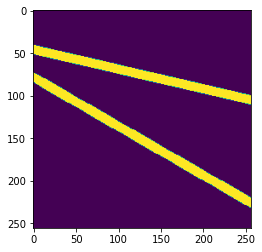

In [3]:
# how to read
p_mask = cv.imread("/media/nevin/Trash Games1/culane/patches/labels/01345_1_2_label.png")
p_mask = p_mask[:, :, 1]
print(p_mask[200][50])
plt.imshow(p_mask)

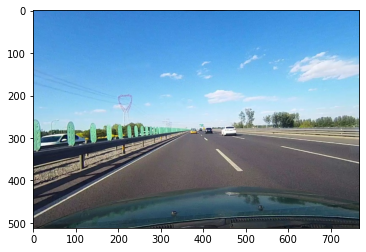

In [108]:
def unpatch():
    img = np.zeros([512, 768, 3])
    patches = patchify(img, (patch_size, patch_size, 3), step=patch_size)

    for i in range(patches.shape[0]):
        for k in range(patches.shape[1]):
            patch_img = cv.imread(path.join(patches_dir, "images/", f"{image.stem}_{i}_{k}.png"))
            patch_img = cv.cvtColor(patch_img, cv.COLOR_BGR2RGB)

            plt.imshow(patch_img)

            if patch_img is None:
                raise Exception("No patch image")

            patches[i, k, 0, :, :, :] = patch_img.copy()
            # print(patches[i][k][0][0])
            # plt.imshow(patches[i][k][0])

    # print(patches[0][0][0])
    reconstructed_img = unpatchify(patches, img.shape).astype(np.uint8)
    plt.imshow(recons)
    # print(img.shape)

unpatch()